In [5]:
!pip install pandas numpy seaborn matplotlib scikit-learn openpyxl transformers datasets evaluate torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00


In [18]:
# Import necessary libraries

import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
import evaluate

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline

from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Task 1: Preparing Data

In [14]:
# List of Excel files
files = ["Business.xlsx", "Opinion.xlsx", "Sports.xlsx", "Political_gossip.xlsx", "World_news.xlsx"]

# Initialize an empty list to store processed DataFrames
processed_dfs = []

# Loop through each file and process it
for file in files:
    # Read the Excel file
    df = pd.read_excel(file)

    # Add a new column 'class' with the name of the file (without extension)
    df['class'] = os.path.splitext(file)[0]

    # Drop the unnamed column (usually labeled as 'no' or 'Unnamed: 0')
    if 'no' in df.columns:
        df.drop(columns=['no'], inplace=True)
    elif 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

    # Drop the 'title' column
    df.drop(columns=['title'], inplace=True)

    # Remove duplicate rows based on the 'content' column
    df.drop_duplicates(subset='content', inplace=True)

    # Append the processed DataFrame to the list
    processed_dfs.append(df)

# Combine all processed DataFrames into a single DataFrame
final_df = pd.concat(processed_dfs, ignore_index=True)

# Save the final DataFrame to a new Excel file
final_df.to_excel("Daily_Mirror_News.xlsx", index=False)

# Display the first few rows of the final DataFrame
final_df.head()

,content,class
0,Sri Lanka’s inflation is expected to increase ...,Business
1,President Anura Kumara Dissanayake,Business
2,As artificial intelligence (AI) evolves from b...,Business
3,A group of Ride for Ceylon participants from t...,Business
4,The ASPI closed in green as a result of price ...,Business


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('content').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Task 2: EDA & Text Preprocessing

In [17]:
# Load the dataset prepared in Task 1
df = pd.read_excel("Daily_Mirror_News.xlsx")

# Display the first few rows of the dataset
print("Dataset Overview:")
print(df.head())


Dataset Overview:
                                             content     class
0  Sri Lanka’s inflation is expected to increase ...  Business
1                 President Anura Kumara Dissanayake  Business
2  As artificial intelligence (AI) evolves from b...  Business
3  A group of Ride for Ceylon participants from t...  Business
4  The ASPI closed in green as a result of price ...  Business



Generating Word Clouds for Each Class...


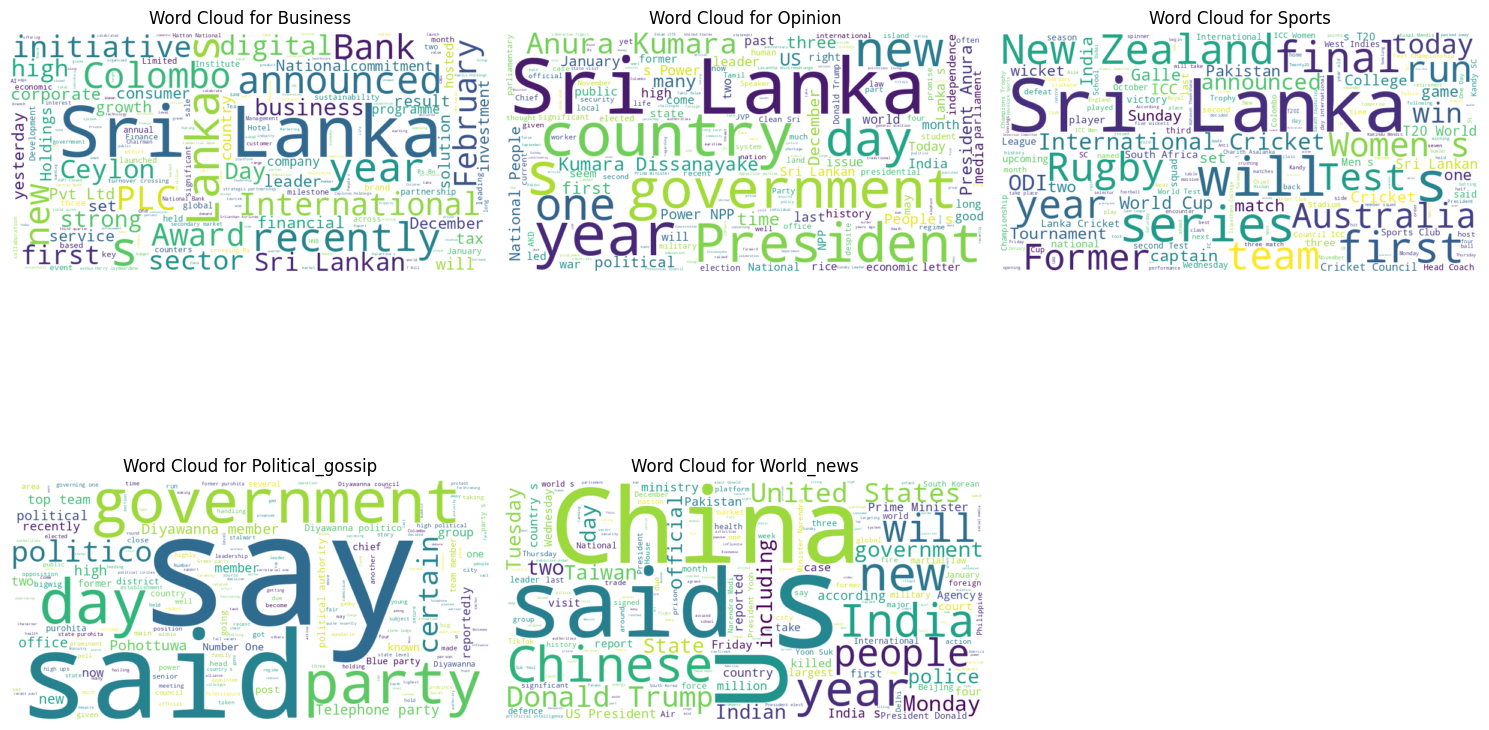

In [19]:
## a. Word Cloud for Each Class
print("\nGenerating Word Clouds for Each Class...")
plt.figure(figsize=(15, 10))
for i, category in enumerate(df['class'].unique(), 1):
    # Combine all content for the current class, excluding NaN values
    text = " ".join(str(content) for content in df[df['class'] == category]['content'].dropna())

    # Generate Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot Word Cloud
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {category}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [22]:
## b. Most Common Bigrams
print("\nMost Common Bigrams Across All Content:")
all_content = " ".join(str(content) for content in df['content'].dropna())  # Exclude NaN values
tokens = word_tokenize(all_content.lower())
bigrams = list(nltk.bigrams(tokens))
bigram_freq = Counter(bigrams).most_common(10)

print("Top 10 Bigrams:")
for bigram, freq in bigram_freq:
    print(f"{bigram}: {freq}")


Most Common Bigrams Across All Content:
Top 10 Bigrams:
('’', 's'): 360
('of', 'the'): 278
('sri', 'lanka'): 270
('in', 'the'): 254
('.', 'the'): 231
(',', 'the'): 130
('to', 'the'): 121
('.', 'a'): 109
('for', 'the'): 103
('at', 'the'): 100


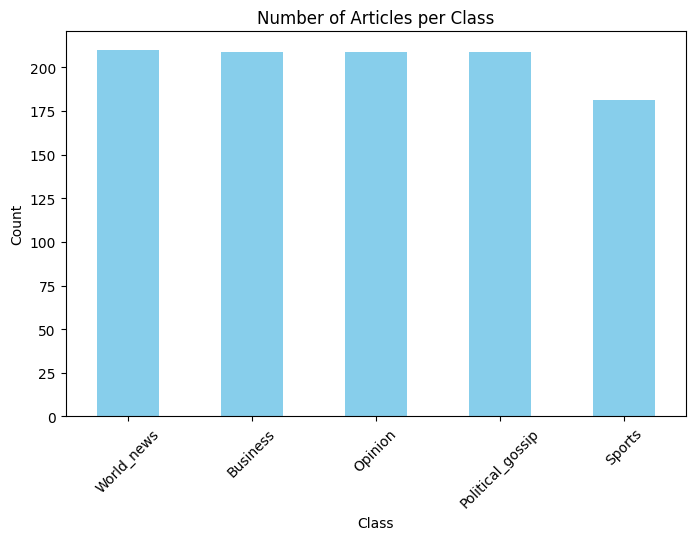

In [27]:
# c. Plot a bar chart
class_counts = df['class'].value_counts()

plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Articles per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

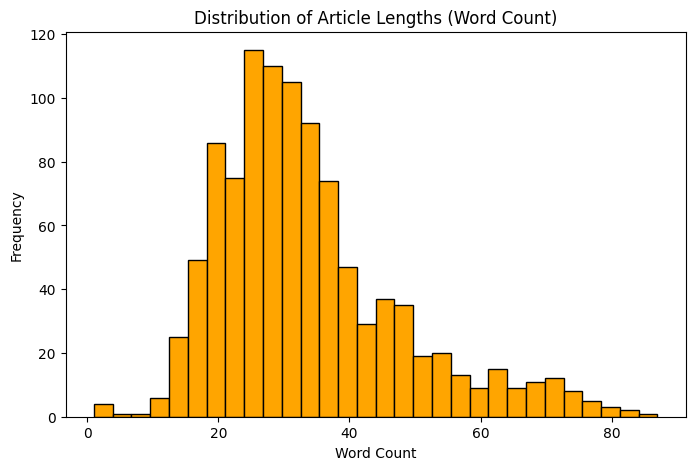

In [28]:
# d. Plot a histogram of word counts
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
plt.hist(df['word_count'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Article Lengths (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

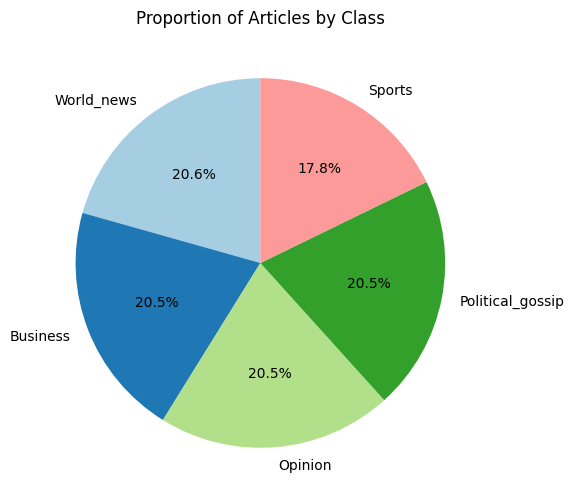

In [29]:
# e. Plot a pie chart for class distribution
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Proportion of Articles by Class')
plt.show()

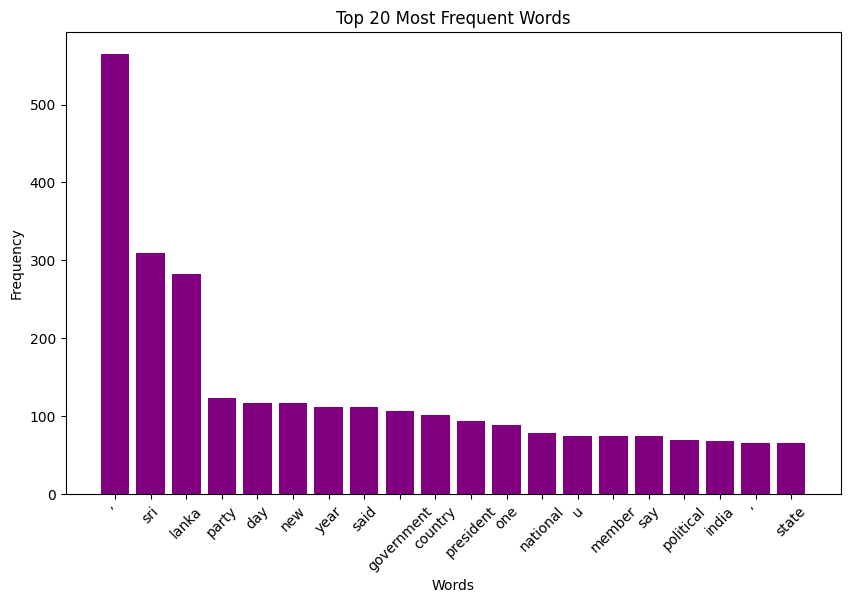

In [30]:
# Get top 20 most frequent words
all_words = " ".join(df['preprocessed_content']).split()
word_freq = Counter(all_words)

# Plot bar chart
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='purple')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [23]:
## Define preprocessing functions
def preprocess_text(text):
    # Step 1: Lowercase the text
    text = text.lower()

    # Step 2: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 3: Tokenize the text
    tokens = word_tokenize(text)

    # Step 4: Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Step 5: Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Step 6: Join tokens back into a single string
    preprocessed_text = " ".join(tokens)

    return preprocessed_text

In [24]:
# Apply preprocessing to a sample record
sample_record = df['content'].dropna().iloc[0]  # Ensure no NaN values
print("\nOriginal Sample Record:")
print(sample_record)

preprocessed_sample = preprocess_text(sample_record)
print("\nPreprocessed Sample Record:")
print(preprocessed_sample)


Original Sample Record:
Sri Lanka’s inflation is expected to increase “sizeably” in the third quarter this year (3Q25), with the possibility of it hovering around 2 percentage points above the inflation target in mid-2026, the Central Bank of Sri Lanka (CBSL) said in its monetary policy report that was released yesterday.

Preprocessed Sample Record:
sri lanka ’ inflation expected increase “ sizeably ” third quarter year 3q25 possibility hovering around 2 percentage point inflation target mid2026 central bank sri lanka cbsl said monetary policy report released yesterday


In [25]:
# Justification for Each Preprocessing Step
print("\nJustification for Each Preprocessing Step:")
print("1. Lowercasing: Ensures uniformity by converting all text to lowercase.")
print("2. Removing Punctuation: Removes unnecessary symbols that do not contribute to meaning.")
print("3. Tokenization: Breaks text into individual words for further processing.")
print("4. Removing Stopwords: Eliminates common words (e.g., 'the', 'is') that add no semantic value.")
print("5. Lemmatization: Reduces words to their base forms (e.g., 'running' -> 'run') for consistency.")



Justification for Each Preprocessing Step:
1. Lowercasing: Ensures uniformity by converting all text to lowercase.
2. Removing Punctuation: Removes unnecessary symbols that do not contribute to meaning.
3. Tokenization: Breaks text into individual words for further processing.
4. Removing Stopwords: Eliminates common words (e.g., 'the', 'is') that add no semantic value.
5. Lemmatization: Reduces words to their base forms (e.g., 'running' -> 'run') for consistency.


In [26]:
# Apply preprocessing to the entire dataset
df['preprocessed_content'] = df['content'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else "")
print("\nPreprocessed file saved as 'Preprocessed_Daily_Mirror_News.xlsx'")
df.to_excel("Preprocessed_Daily_Mirror_News.xlsx", index=False)


Preprocessed file saved as 'Preprocessed_Daily_Mirror_News.xlsx'


# Task 3: Select a Hugging Face Model

Selected Model: https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english

The distilbert-base-uncased-finetuned-sst-2-english model is a lightweight and efficient version of BERT, fine-tuned for sentiment analysis on the Stanford Sentiment Treebank (SST-2) dataset. While this model is pre-trained for sentiment classification (positive/negative), we can further fine-tune it for news classification task with this custom dataset.

# Task 4: Finetune a Pre-trained Hugging Face Model

In [9]:
# Load the Excel file into a Pandas DataFrame
df = pd.read_excel("Preprocessed_Daily_Mirror_News.xlsx")

# Select relevant columns
df = df[["preprocessed_content", "class"]]

# Rename columns for clarity
df.columns = ["text", "label"]

# Map class labels to integers (required for classification)
label_mapping = {
    "Business": 0,
    "Opinion": 1,
    "Sports": 2,
    "Political_gossip": 3,
    "World_news": 4
}
df["label"] = df["label"].map(label_mapping)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

# Convert Pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [11]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Define a function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Clean the dataset to remove invalid entries
train_dataset = train_dataset.filter(lambda example: example["text"] is not None and len(example["text"].strip()) > 0)
val_dataset = val_dataset.filter(lambda example: example["text"] is not None and len(example["text"].strip()) > 0)

# Tokenize the training and validation datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Filter:   0%|          | 0/814 [00:00<?, ? examples/s]

Filter:   0%|          | 0/204 [00:00<?, ? examples/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [14]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english",
    num_labels=len(label_mapping),  # Update the number of labels to match your dataset
    ignore_mismatched_sizes=True    # Ignore size mismatches and reinitialize the classification head
)
# Load the accuracy metric using the `evaluate` library
accuracy_metric = evaluate.load("accuracy")

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-ab0012ed17b9>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anuhasindumina (anuhasindumina-university-of-moratuwa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,1.150200,1.060966,0.724138
2,0.777000,0.762970,0.798030
3,0.621100,0.639788,0.842365


TrainOutput(global_step=153, training_loss=0.9471274848077812, metrics={'train_runtime': 379.9829, 'train_samples_per_second': 6.411, 'train_steps_per_second': 0.403, 'total_flos': 80676961827840.0, 'train_loss': 0.9471274848077812, 'epoch': 3.0})

In [15]:
# Evaluate the model
eval_results = trainer.evaluate()

print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.6397880911827087, 'eval_accuracy': 0.8423645320197044, 'eval_runtime': 0.8565, 'eval_samples_per_second': 237.001, 'eval_steps_per_second': 15.177, 'epoch': 3.0}


In [19]:
# Get predictions on the validation set
predictions = trainer.predict(val_dataset)
logits = predictions.predictions
labels = predictions.label_ids

# Convert logits to predicted class labels
predicted_labels = np.argmax(logits, axis=-1)

In [20]:
# Map numeric labels back to class names
label_names = list(label_mapping.keys())  # e.g., ["Business", "Opinion", "Sports", ...]

# Generate the classification report
report = classification_report(labels, predicted_labels, target_names=label_names)

print("Classification Report:")
print(report)

Classification Report:
                  precision    recall  f1-score   support

        Business       0.80      0.86      0.83        42
         Opinion       0.72      0.71      0.72        41
          Sports       0.97      0.97      0.97        36
Political_gossip       0.93      0.90      0.92        42
      World_news       0.80      0.79      0.80        42

        accuracy                           0.84       203
       macro avg       0.85      0.85      0.85       203
    weighted avg       0.84      0.84      0.84       203



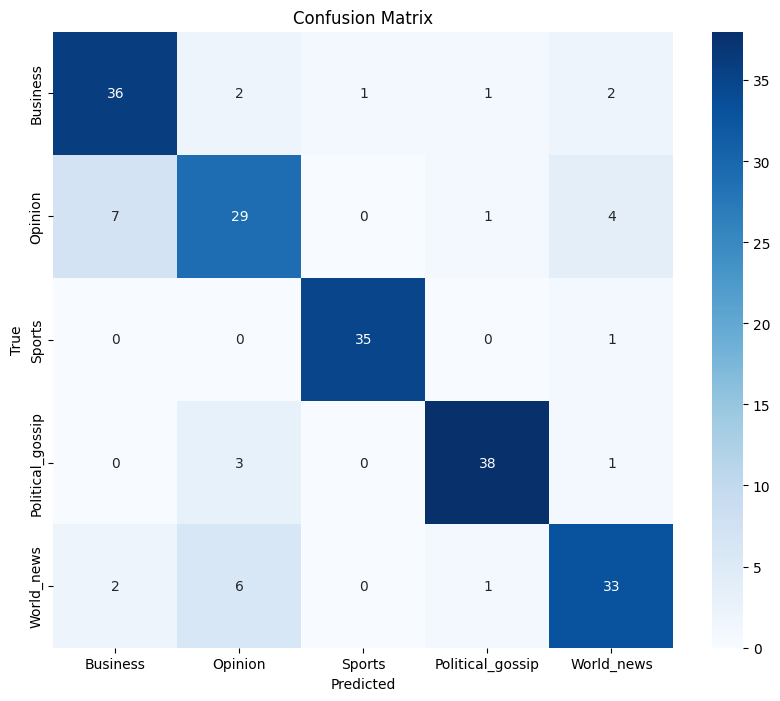

In [21]:
# Generate the confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Save the model and tokenizer
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

In [17]:
# Load the fine-tuned model and tokenizer
classifier = pipeline("text-classification", model="./fine_tuned_model", tokenizer="./fine_tuned_model")

# Example inference
sample_text = "The stock market saw a significant rise today."
prediction = classifier(sample_text)

print(f"Prediction: {prediction}")

Device set to use cuda:0


Prediction: [{'label': 'LABEL_0', 'score': 0.39752197265625}]


In [23]:
# Reverse mapping (numeric label -> category name)
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

In [24]:
def predict_category(text):
    prediction = classifier(text)
    predicted_label_id = int(prediction[0]['label'].split('_')[-1])
    predicted_category = reverse_label_mapping[predicted_label_id]
    return predicted_category

# Example usage
sample_text = "The stock market saw a significant rise today."
predicted_category = predict_category(sample_text)
print(f"Predicted Category: {predicted_category}")

Predicted Category: Business


In [26]:

# Load the evaluations.csv file
evaluations_df = pd.read_csv("evaluation.csv")

# Check the structure of the DataFrame
print(evaluations_df.head())

                                             content
0  On the 25th of February 1938, the Wilpattu Nat...
1  The Finance Ministry this week invited Express...
2  The Center for Poverty Analysis (CEPA) is set ...
3  The secondary market yield curve commenced the...
4  Access Logistics Park Ekala (Pvt.) Ltd, a whol...


In [28]:
# Predict the category for each row in the content column
evaluations_df["predicted_category"] = evaluations_df["content"].apply(predict_category)

# Check the updated DataFrame
print(evaluations_df.head())

# Save the results to an Excel file
evaluations_df.to_excel("predicted_evaluations.xlsx", index=False)

                                             content predicted_category
0  On the 25th of February 1938, the Wilpattu Nat...           Business
1  The Finance Ministry this week invited Express...           Business
2  The Center for Poverty Analysis (CEPA) is set ...           Business
3  The secondary market yield curve commenced the...   Political_gossip
4  Access Logistics Park Ekala (Pvt.) Ltd, a whol...           Business
